# Using Sentence Embeddings from SBERT

By Indira Sen

This notebook will demonstrate how to use a powerful unsupervised technique, sentence embeddings, for a variety of tasks. We will specifically use SBERT (https://www.sbert.net/index.html)

The paper: [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/abs/1908.10084)

In [15]:
import pandas as pd

In [16]:
# ! pip install -U sentence-transformers

In [17]:
from sentence_transformers import SentenceTransformer, util

import numpy as np
import timeit

from sklearn.metrics.pairwise import cosine_similarity

## Example

There are many pretrained models to choose from: https://www.sbert.net/docs/pretrained_models.html

The best model is currently 'sentence-t5-xxl' which scored highly in semantic similarity benchmarks. However, it needs quite some space to load and takes time as well, so we will use the more light-weight 'paraphrase-distilroberta-base-v1'.

In [18]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-distilroberta-base-v1') # the pretrained model we will be using

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Length of the embedding:", len(embedding)) # depends on the pretrained model
    print("First five items in the embedding:", embedding[:5])
    print()

Sentence: This framework generates embeddings for each input sentence
Length of the embedding: 768
First five items in the embedding: [ 0.19731529  0.12105348 -0.25813296  0.02697724 -0.17997529]

Sentence: Sentences are passed as a list of string.
Length of the embedding: 768
First five items in the embedding: [-0.25747895  0.2462938   0.09469668  0.30377313  0.15252715]

Sentence: The quick brown fox jumps over the lazy dog.
Length of the embedding: 768
First five items in the embedding: [ 0.05094908  0.24235855  0.15774004 -0.29798466  0.04995686]



In [61]:
# let's find the semantic textual similarity using cosine distance
# Two lists of sentences
sentences1 = ['The cat sits outside',
             'A man is playing guitar',
             'The new movie is awesome']

sentences2 = ['The dog plays in the garden',
              'A woman watches TV',
              'The new movie is so great']

#Compute embedding for both lists
embeddings1 = model.encode(sentences1, convert_to_tensor=True)
embeddings2 = model.encode(sentences2, convert_to_tensor=True)

#Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings1, embeddings2)

#Output the pairs with their score
for i in range(len(sentences1)):
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences1[i], sentences2[i], cosine_scores[i][i]))

The cat sits outside 		 The dog plays in the garden 		 Score: 0.4579
A man is playing guitar 		 A woman watches TV 		 Score: 0.1759
The new movie is awesome 		 The new movie is so bad 		 Score: 0.7568


We can use SBERT for a range of different things. For all of them, we need to do two things:
- embed our documents
- find the similarity between documents

In [19]:
# these are the two main functions we need and we will reuse them for all different use cases
def embed(documents, model_type = 'paraphrase-distilroberta-base-v1'):
    sbert_model = SentenceTransformer(model_type)
    start = timeit.default_timer()
    embeddings = sbert_model.encode(documents)
    stop = timeit.default_timer()

    print("time taken for %d: %f" %(len(documents), stop-start))
    return embeddings



def find_similarity(embedded_documents, references):
    ref_embedding = embed(references)
    return util.cos_sim(embedded_documents, ref_embedding)

In [20]:
# we have an additional function for plotting

import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_sim_dist(data, dims):
  num_dims = len(dims)
  fig, axs = plt.subplots(nrows=1, ncols=num_dims,
                         figsize = (3*num_dims, 4),
                         sharex = True, sharey = 'row')
  for num in range(num_dims):
    data[dims[num]].sort_values().plot(kind = 'hist', ax = axs[num])
    axs[num].set_title("%s" %(dims[num]), fontsize = 14)
    axs[num].set_xlabel("similarity", fontsize = 12)
    subtitle = dims[num]

## Part 1: Semantic Search of Advice Forum Questions

We first use SBERT to search a large corpus of *unlabeled* documents for relevant or related documents based on a *query*. This is similar to information retrieval via a search engine. Crucially, our search is not just based on exact word matches, but based on **semantic** similarity.

In [21]:
# we will use a dataset of advice for this, specifically from: https://pudding.cool/2018/11/dearabby/

advice_data = pd.read_csv('https://raw.githubusercontent.com/the-pudding/data/master/dearabby/raw_da_qs.csv')
advice_data

,year,month,day,url,title,letterId,question_only
0,1985,1.0,01,proquest,WOMAN NEEDS HELP: HER BURDEN OF HOPELESSNESS I...,1,i have been in a bad marriage for 40 years. i ...
1,1985,1.0,01,proquest,WOMAN NEEDS HELP: HER BURDEN OF HOPELESSNESS I...,1,"this is for all newspaper carriers, mail carri..."
2,1985,1.0,02,proquest,LAMENT ABOUT OLD AGE AND SICKNESS IS ILL-ADVISED,1,our 16-year-old son recently was placed in a s...
3,1985,1.0,03,proquest,'NORMAL' WIDOW HAS AN EYE FOR THE GUYS,1,"i was a happy, respectable wife for 40 years, ..."
4,1985,1.0,04,proquest,IT'S WISE TO BE WARY WHEN A STRANGER COMES TO ...,1,you be the judge: last night about 7 p.m. i wa...
...,...,...,...,...,...,...,...
20029,2017,1.0,3,http://www.uexpress.com/dearabby/2017/1/3,Secret Baptism for Baby Is Scheme That's All Wet,1,my niece has a 1-year-old son. neither my niec...
20030,2017,1.0,3,http://www.uexpress.com/dearabby/2017/1/3,Housekeeper Has Message of Kindness for Snobbi...,2,please post my message for people to be more c...
20031,2017,1.0,3,http://www.uexpress.com/dearabby/2017/1/3,Couple's Plan to Live Together Meets Parental ...,3,"after a year together, my boyfriend recently p..."
20032,2017,1.0,2,http://www.uexpress.com/dearabby/2017/1/2,Deceased Grandma Still Lives Through Grandpa's...,1,my mother-in-law passed away two years ago fro...


In [22]:
advice_data['title'].values[0:5]

array(['WOMAN NEEDS HELP: HER BURDEN OF HOPELESSNESS IS TOO HEAVY TO CARRY',
       'WOMAN NEEDS HELP: HER BURDEN OF HOPELESSNESS IS TOO HEAVY TO CARRY',
       'LAMENT ABOUT OLD AGE AND SICKNESS IS ILL-ADVISED',
       "'NORMAL' WIDOW HAS AN EYE FOR THE GUYS",
       "IT'S WISE TO BE WARY WHEN A STRANGER COMES TO THE DOOR"],
      dtype=object)

In [23]:
advice_data['question_only'].values[0:5]

array(["i have been in a bad marriage for 40 years. i knew it was a mistake after the first year, but being a catholic, i accepted it as my cross. i bore eight children, hating every minute of it.\nthere was never enough money, so i started teaching school when my youngest was 4. i'm 60 now and feel like 85. i'm sick of marriage, sick of my family and sick of life in general.\nsuicide would cut off insurance and be hard on my family. is there a place where i can get some information on how to end my life and make it look like an accident?\nevery night i pray i won't wake up the next morning.\nhelpless in hell",
       "this is for all newspaper carriers, mail carriers and delivery people: when you see a dog, barking and growling in front of someone's house, turn right around and forget that house.\ntoday, a delivery boy tried to get up to our front door when he was confronted by our dog on a chain, growling and snapping frantically. the delivery boy didn't take the hint; instead he kep

In [24]:
# we will use a sample because embedding 20K documents could take some time
advice_data = advice_data.sample(1000)

In [25]:
# let's embed the questions
documents = advice_data['question_only'].values
document_embeddings = embed(documents)

time taken for 1000: 211.471733


In [26]:
# let's search for questions related to 'marriage', 'abortion', 'health', 'religion'
queries = ['marriage', 'abortion', 'health', 'religion']
query_sims = find_similarity(document_embeddings, queries)
type(query_sims)

time taken for 4: 0.060231


torch.Tensor

In [27]:
query_sims.shape

torch.Size([1000, 4])

In [28]:
query_sims[0] # similarity of first question with the four topics

tensor([0.1006, 0.1193, 0.0954, 0.1204])

In [29]:
advice_data['question_only'].values[0]

'this is not a perfect world, so, to the people who are bothered by their neighbors\' floodlights, may i suggest that they move?\nwe live out in the sticks of west virginia. it takes the state police or sheriff 30 minutes to get to our house, the fire department 15 minutes.\nwe farm and have a lot of equipment to worry about. one small tractor costs more than $20,000. everything is engraved with our license numbers for the police to trace if stolen.\nif we lived in a perfect world, we wouldn\'t need lights to protect us. we have six 150-watt mercury vapor lights shining bright and locks on the barns, and still gasoline is stolen from our truck parked in the driveway.\nwhen some of our cars were stolen, the insurance company refused to pay. why? no locks on the gates! our woods are used for a sexual fun house. in spite of the "no trespassing" signs, someone grew pot in seven containers in our woods last year. there are varmints in the country, both the four-legged and two-legged variety

Let's find the top 5 questions related to each query.

In [30]:
# loop through the sim matrix and get the similarities for each query and create a new df column
for i, query in enumerate(queries):
  advice_data['%s_sim' %query] = query_sims.T[i]

advice_data.head(5)

,year,month,day,url,title,letterId,question_only,marriage_sim,abortion_sim,health_sim,religion_sim
4988,1993,5.0,05,proquest,Son's laughter during funeral confused mom,1,"this is not a perfect world, so, to the people...",0.100633,0.119288,0.095358,0.120365
9822,2003,6.0,14,http://www.uexpress.com/dearabby/2003/6/14,Wife's Blistering Volleys Must Be Met Head On,3,how do people know if their therapist is reall...,-0.050387,-0.013095,0.149036,0.025632
3026,1989,6.0,25,proquest,"Dating this guy will lead to bed, not the altar",1,"two months ago, my daughter's fiance died. ""co...",0.104229,0.169667,0.038974,0.043868
660,1985,7.0,12,-,Dear Abby: Comments Have the Ring of Passion,1,what's all this static about whether or not a ...,-0.007496,0.090002,0.148223,0.095038
13091,2008,6.0,10,http://www.uexpress.com/dearabby/2008/6/10,Obituary Photos Can Be a Window Into the Past,1,i just read the letter from the reader (april ...,0.059776,0.073948,0.083986,0.028231


In [31]:
# now you can pick whichever column/query and find the most similar questions
top_5 = advice_data.sort_values('religion_sim', ascending = False).head(5)
for _, row in top_5.iterrows():
   print(row['religion_sim'])
   print(row['question_only'])
   print()

0.2843557298183441
you recently reminded your readers about international forgiveness week, which is a wonderful idea. however, it is nothing new. in the jewish religion, there has been a "forgiveness fortnight" for at least 2,000 years.
during the 10 days between rosh hashanah and yom kippur, those of the jewish faith are commanded to ask forgiveness from those whom they may have offended or wronged during the year. in judaism, god cannot forgive the sins a person has committed against another unless the sinner has asked that person for forgiveness. if the injured party rejects the apology three times, the wrongdoer is then released from his or her obligation to ask forgiveness.
isn't this a beautiful tradition, as well as a good way to begin a new year? esther krisman, los angeles

0.2803325355052948
during the past year, i have become good friends with a lady i'll call ivy. i am a 36-year-old single woman; ivy is 53 and divorced. we enjoy each other's company and she's been a wonder

In [32]:
top_5 = advice_data.sort_values('health_sim', ascending = False).head(5)
for _, row in top_5.iterrows():
   print(row['health_sim'])
   print(row['question_only'])
   print()

0.23034541308879852
my husband has an extensive list of health issues, both mental and physical. his family has a history of cancer. last week, we were given the news that he may have pancreatic cancer. he watched his brother die from the same disease, so we know that if he is diagnosed, he may not survive long. the doctors weren't able to make a definitive diagnosis, so there will be more testing. i love my husband with all my heart and have stood by him through everything.
my dilemma: after we got the news, i started thinking about what may happen to me after he dies. i thought about getting him more life insurance, selling the house, what to do with his belongings -- even where i would bury him. am i a terrible person? i feel guilty for doing it and would appreciate your opinion. -- filled with all sorts of emotions

0.2255341112613678
i have fought obesity all of my adult life, and my weight has yo-yoed over the years. my problem is, when i go to the doctor's office and i am taken 

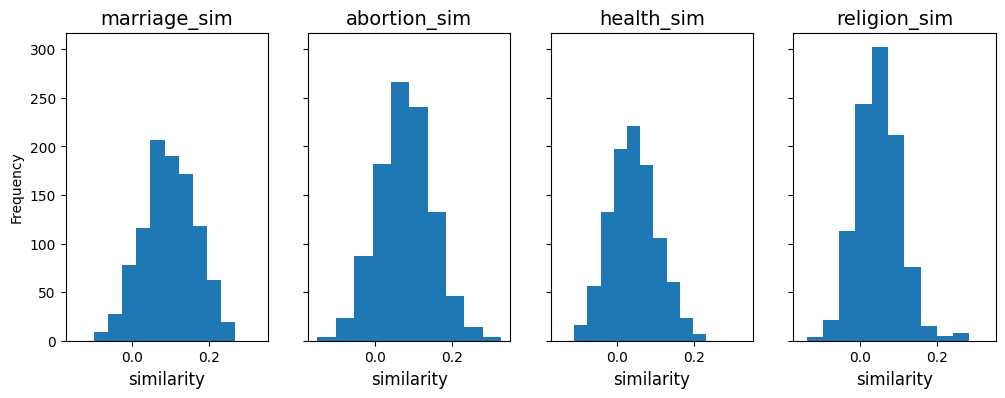

In [34]:
# we can also visualize the distribution of similarity scores
plot_sim_dist(advice_data, [i+'_sim' for i in queries])

You can check outother faster ways of doing this here: https://www.sbert.net/examples/applications/semantic-search/README.html

**Try yourself**:

1. sometimes SBERT does not work well for long multi-sentence documents, especially if the different sentences span multiple topics. You can try and tokenize the sentences of your documents to see if it captures better/more relevant sentences.

Think about how you pick the documents in this case. For example, you could have a very liberal estimate and say that if any document has a single relevant sentence, it should be considered relevant.

2. Experiment with different pretrained models: https://www.sbert.net/docs/pretrained_models.html

## Part 2: Detecting Workplace Depression

SBERT can also be used for other cases, specifically as a light-weight classifier. Details on how we used it to detect workplace depression is here: https://docs.google.com/presentation/d/1i6sKdoGR35UcsU7re0mLRWZ3OZinYx9xWnKRR7Bwb-8/edit?usp=sharing




In [35]:
glassdoor_data = pd.read_csv('glassdoor_us_sample.csv')
glassdoor_data.head()

,Unnamed: 0,advice_to_mgmt,company_id,cons,cons_vader,date,employee_status,employee_title,helpful,location,...,state,SEC filings,GICSSector,GICSSubIndustry,Headquarters Location,Date first added,CIK,Founded,Region,Division
0,155609,NaN,1625_hartford,No longer has a good training program. ZERO wo...,NaN,Mon Aug 12 2013 16:47:19 GMT+0100 (British Sum...,Former Employee,Claims Adjuster,NaN,"Tampa, FL",...,FL,reports,Financials,Property & Casualty Insurance,"Hartford, Connecticut",NaN,874766.0,NaN,South,South Atlantic
1,145990,NaN,14836_bankofamerica,So true I lost my job after 26 years. Reorgani...,NaN,Wed Dec 24 2014 05:23:42 GMT+0000 (Greenwich M...,"Coordinator in Saint Petersburg, FL",NaN,NaN,"Saint Petersburg, FL",...,FL,reports,Financials,Diversified Banks,"Charlotte, North Carolina",30/06/1976,70858.0,NaN,South,South Atlantic
2,249858,NaN,2391_pnc,no challenging work. No appreciation/recogniti...,NaN,Sun Jun 09 2013 17:00:25 GMT+0100 (British Sum...,Current Contractor,Lead Software Engineer,NaN,"Pittsburgh, PA",...,PA,reports,Financials,Regional Banks,"Pittsburgh, Pennsylvania",30/04/1988,713676.0,NaN,Northeast,Middle Atlantic
3,115197,NaN,289_americantower,"managers beat you down, unprofessional.",NaN,Tue Jul 14 2015 15:10:17 GMT+0100 (British Sum...,"Project Manager in Los Angeles, CA",NaN,NaN,"Los Angeles, CA",...,CA,reports,Utilities,Electric Utilities,"Columbus, Ohio",NaN,4904.0,1906,West,Pacific
4,320062,NaN,1660_bestbuy,Low pay and managers take to long to deal with...,NaN,Tue Mar 13 2018 04:22:35 GMT+0000 (Greenwich M...,Current Employee,"Geek Squad, Consultation Agent",NaN,"Everett, WA",...,WA,reports,Consumer Discretionary,Computer & Electronics Retail,"Richfield, Minnesota",29/06/1999,764478.0,NaN,West,Pacific


In [36]:
glassdoor_data.columns

Index(['Unnamed: 0', 'advice_to_mgmt', 'company_id', 'cons', 'cons_vader',
       'date', 'employee_status', 'employee_title', 'helpful', 'location',
       'post_index', 'pros', 'pros_conflict', 'pros_fun', 'pros_identity',
       'pros_vader', 'rating_balance', 'rating_career', 'rating_comp',
       'rating_culture', 'rating_mgmt', 'rating_overall', 'review_title',
       'review_title_vader', 'whole_review_text', 'years_at_company',
       'vader_pros', 'vader_cons', 'vader_review_title', 'flair_pros',
       'flair_cons', 'stress_post', 'company_name', 'post_id', 'state',
       'SEC filings', 'GICSSector', 'GICSSubIndustry', 'Headquarters Location',
       'Date first added', 'CIK', 'Founded', 'Region', 'Division'],
      dtype='object')

There are lots of columns, but we mainly care about the text ones which are 'pros', 'cons', 'whole_review_text'.

In [37]:
glassdoor_data['whole_review_text'].values[0:5]

array(["Terrible pay and an extremely high turnover rate.. I can't think of one pro.. No longer has a good training program. ZERO work/life balance. Lowest pay in the insurance industry.",
       'Loan officer. Good company health benefits & time off. So true I lost my job after 26 years. Reorganization and did not offer another position.',
       'Good for work life balance. work life balance and flexibility.. no challenging work. No appreciation/recognition for contractors',
       'Project Manager. salary was good but not worth it.... managers beat you down, unprofessional.',
       'Fun place to work, with great people.. A lot of room to grow and advancement within the company!. Low pay and managers take to long to deal with bad employees.'],
      dtype=object)

In [38]:
glassdoor_data['cons'].values[0:5]

array(['No longer has a good training program. ZERO work/life balance. Lowest pay in the insurance industry.',
       'So true I lost my job after 26 years. Reorganization and did not offer another position.',
       'no challenging work. No appreciation/recognition for contractors',
       'managers beat you down, unprofessional.',
       'Low pay and managers take to long to deal with bad employees.'],
      dtype=object)

We want to find texts that have markers of 'workplace dperession', so we use the survey items in the Occupational Depression Inventory (ODI) as references. One of them is about fatigue.

In [39]:
fatigue = 'I felt exhausted because of my work.'
depression = 'I felt depressed because of my job.'

In [40]:
# let's embed the cons
documents = glassdoor_data['cons'].values
document_embeddings = embed(documents)

time taken for 1000: 69.893965


In [41]:
# let's get similarity to the fatigue and depression survey items
odi_sims = find_similarity(document_embeddings, [fatigue, depression])
odi_sims.shape

time taken for 2: 0.098393


torch.Size([1000, 2])

In [42]:
# let's add them to the dataframe
glassdoor_data['fatigue_sim'] = odi_sims.T[0]
glassdoor_data['depression_sim'] = odi_sims.T[1]

In [43]:
# let's find the top instances related to fatigue
top_5 = glassdoor_data.sort_values('fatigue_sim', ascending = False).head(5)
for _, row in top_5.iterrows():
   print(row['fatigue_sim'])
   print(row['cons'])
   print()

0.5658976435661316
Towards the end I really wasn't making my hours. I was FullTime yet tasks I had onve been assigned were either finished too early by others staying for OverTime or tasks they cut out.

0.5448348522186279
Work can be thankless and exhausting

0.45268142223358154
I worked in nathans they had in the kmart where I worked. it was horrible, I always worked by myself which meant I had to ring up customers and make the food, it got hectic especially on a Friday night or Saturday. I left because the job became too stressful and for 7.25 its not worth it at all.

0.4314321279525757
Low pay because of short hours, management, physically exhausting, overworked and underpaid

0.4268292784690857
My commute was too long; a state away.



In [44]:
# let's find the top instances related to depression
top_5 = glassdoor_data.sort_values('depression_sim', ascending = False).head(5)
for _, row in top_5.iterrows():
   print(row['depression_sim'])
   print(row['cons'])
   print()

0.4943542778491974
So true I lost my job after 26 years. Reorganization and did not offer another position.

0.46584856510162354
everything else, this was the worst job I've ever had

0.45960503816604614
Grittiness of job and salary

0.45140206813812256
The company treats employees like dirt. You are always scared for your job. The company does not offer relocation packages for the majority of the jobs posted. I was offered a position in another city and was only offered lateral pay and no relocation and was under pressure from my bosses to take the job or else no chance of moving up again. When I couldn't afford to move I was not allowed to have another position and was terminated. Being a store manager is a miserable existence where you have no work/life balance and are constantly under stress. You can't unplug because if you try to unplug you fall behind and get in danger of disciplinary action. In my experience I was moved further and further from my house so I had even less work l

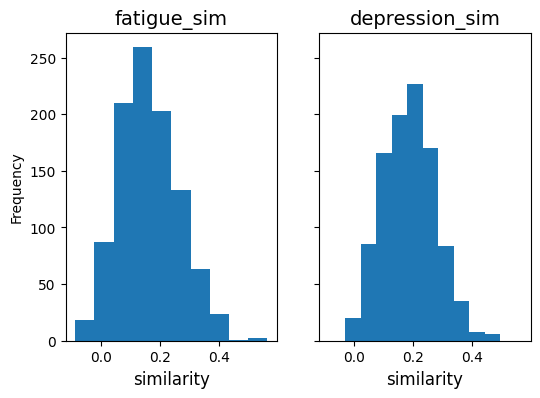

In [45]:
# we can also visualize the distribution of similarity scores
plot_sim_dist(glassdoor_data, ['fatigue_sim', 'depression_sim'])

While it's still a normal distribution, it's somewhat different from the advice ones --- the similarity scores are generally higher. Lower overall similarity scores can indicate that the data is not right for this specific purpose (i.e., too long, not enough overlap with the references or queries, etc.)

## Part 3: Political Stance

Now, we will try this on a political topic. Specifically, we will explore a classification-like setup for detecting political stance using survey items as references.

In [46]:
data = pd.read_csv('raw_test_bernie.csv')
data.head()

,Tweet,Target,Stance
0,"#IEndorseBernie for tons of reasons, but this ...",Bernie Sanders,FAVOR
1,A big problem w/#Bernie left is not only preoc...,Bernie Sanders,AGAINST
2,"This poll is not reflecting anything: ""age was...",Bernie Sanders,AGAINST
3,So proud how @BernieSanders is shedding light ...,Bernie Sanders,FAVOR
4,"According to media bias fact checker, you have...",Bernie Sanders,FAVOR


In [47]:
# let's check the distribution of favor and against
data.groupby('Stance').size()

Stance
AGAINST    292
FAVOR      343
dtype: int64

In [48]:
# get the documents to embed
documents = data['Tweet'].values

In [49]:
# embed them
document_embeddings = embed(documents)

time taken for 635: 58.617651


In [50]:
# define references
pos_ref = 'I strongly agree with Bernie Sanders'
neg_ref = 'I strongly disagree with Bernie Sanders'

In [51]:
# find the similarity with the references
pos_sims = find_similarity(document_embeddings, [pos_ref]) # since the reference is only one document
neg_sims = find_similarity(document_embeddings, [neg_ref]) # since the reference is only one document

time taken for 1: 0.049866
time taken for 1: 0.048048


In [52]:
data['pos_ref_sim'] = pos_sims
data['neg_ref_sim'] = neg_sims

In [53]:
# inspect the most positively similar
data.sort_values('pos_ref_sim', ascending = False).head(10)[['Tweet', 'Stance', 'pos_ref_sim']].values

array([["I agree. Have at it one point at a time. And BRING SOME SOURCES. Please. And thanks. I'm an open-minded #Bernie supporter. Are you?",
        'FAVOR', 0.6265785694122314],
       ['Bernie Sanders: Bernie is always Bernie. Has always been Bernie. Will always be Bernie. Ill let yall decide if thats good or bad. His answer on socialism was awesome. Ive always like Bernie I just dont think Ill vote for him. He can still change my mind #DemocraticDebate',
        'FAVOR', 0.6210218667984009],
       ['I agree #MedicareForAll #GreenNewDeal vote for @BernieSanders to transform our society into a just society that can effectively curb the worst effects of climate change.',
        'FAVOR', 0.584766685962677],
       ["I believe @BernieSanders is our best hope for a better future, and that he should run no matter what. If you agree, let's all tell #Bernie that we'll support him running an Independent ticket? RT, Like, and Comment what you think",
        'FAVOR', 0.5844830274581909],
 

In [54]:
# inspect the most negatively similar
data.sort_values('neg_ref_sim', ascending = False).head(10)[['Tweet', 'Stance', 'neg_ref_sim']].values

array([['Bernie Sanders: Bernie is always Bernie. Has always been Bernie. Will always be Bernie. Ill let yall decide if thats good or bad. His answer on socialism was awesome. Ive always like Bernie I just dont think Ill vote for him. He can still change my mind #DemocraticDebate',
        'FAVOR', 0.6353832483291626],
       ["I can't seem to recall Bernie ever telling people who disagree with him to vote for someone else. I think it's because Bernie isn't just fighting for his supporters. He's fighting for everyone and that includes those who disagree with him.",
        'AGAINST', 0.5637590885162354],
       ['Young people liking Comrade Bernie is really inflated Many seriously do not like nor trust Bernie',
        'AGAINST', 0.5473041534423828],
       ['How about we start with honesty? #BernieSanders is considered the most honest and trustworthy. He has been consistent throughout his career. The other candidates have issues with the truth, have been less compassionate, and sadly 

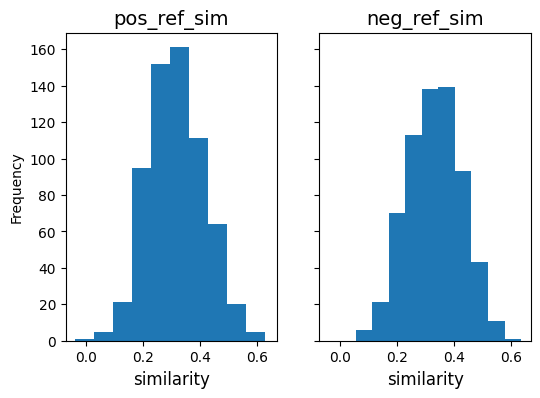

In [55]:
# let's look at the distribution of similarities
plot_sim_dist(data, dims = ['pos_ref_sim', 'neg_ref_sim'])

Let's look at this more quantitatively. First, we will encode the stance labels so that we can find correlations with the similarity scores.

In [56]:
# encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data['Stance'])
data['Stance'] = le.transform(data['Stance'])
data.head()

,Tweet,Target,Stance,pos_ref_sim,neg_ref_sim
0,"#IEndorseBernie for tons of reasons, but this ...",Bernie Sanders,1,0.341556,0.360577
1,A big problem w/#Bernie left is not only preoc...,Bernie Sanders,0,0.299962,0.346068
2,"This poll is not reflecting anything: ""age was...",Bernie Sanders,0,0.269229,0.315527
3,So proud how @BernieSanders is shedding light ...,Bernie Sanders,1,0.391091,0.414384
4,"According to media bias fact checker, you have...",Bernie Sanders,1,0.235165,0.287066


We would expect stance (1 = positive/favor) to be strongly correlated with the positive reference similarity. We would also expect the positive and negative reference similarity to be negatively correlated


In [57]:
# find cross-correlations.
data.corr()

<ipython-input-57-ed27f7a9633f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,Stance,pos_ref_sim,neg_ref_sim
Stance,1.000000,0.102166,-0.025077
pos_ref_sim,0.102166,1.000000,0.902369
neg_ref_sim,-0.025077,0.902369,1.000000


In [58]:
# if we want to take a closer look with p-values
from scipy.stats import pearsonr

pearsonr(data['Stance'], data['pos_ref_sim'])

PearsonRResult(statistic=0.1021656567411946, pvalue=0.009990301129295125)

In [59]:
pearsonr(data['neg_ref_sim'], data['pos_ref_sim'])

PearsonRResult(statistic=0.9023685428679246, pvalue=1.4042616711804649e-233)

On the one hand, we see a small but significant correlation between positive stance and the positive reference similarity, but also a strong and significant relation between the positive and negative similarities.

So, ultimately, while SBERT can detect some types of similarity, it's not very suitable for polarity.